# **Deep Research with Bing Search & Scraping**

This notebook demonstrates an agentic research workflow that leverages Azure AI services to conduct comprehensive web-based research on any topic. The workflow now includes a dedicated scraping phase for extracting and cleaning web content:

1. **Research Planning** - Breaking down complex queries into structured subtopics and targeted search queries
2. **Information Retrieval** - Using Bing Search API through Azure AI Services to gather relevant web content
3. **Web Content Scraping** - Extracting, cleaning, and filtering relevant content from web pages using a ScraperAgent
4. **Content Analysis** - Summarizing scraped results and extracting key insights
5. **Report Generation** - Creating detailed research reports with proper citations
6. **Peer Review** - Evaluating report quality and suggesting improvements until quality standards are met

The notebook orchestrates multiple specialized AI agents working together:
- PlannerAgent - Creates comprehensive research plans with subtopics and queries
- BingSearchAgent - Retrieves relevant search results from the web
- WebScraperAgent - Extracts, cleans, and filters relevant content from web pages
- SummaryAgent - Extracts key insights from scraped content
- ResearchAgent - Compiles findings into structured research reports
- PeerReviewAgent - Provides quality feedback in a continuous improvement loop

Built with Azure OpenAI, Azure AI Projects, and the OpenAI Agents SDK.

## Environment Setup

First, we'll set up our environment by importing necessary libraries and loading environment variables from a .env file. These environment variables contain configuration details such as API keys and endpoints for the Azure OpenAI and Bing Search services.

In [1]:
import dotenv
dotenv.load_dotenv(".env", override=True)

True

### Configure Azure OpenAI to work with OpenAI Agents SDK

In [2]:
import os
from agents import (
    set_default_openai_client,
    set_tracing_disabled,
    OpenAIChatCompletionsModel
)

# setup settings
from openai import AsyncAzureOpenAI
import nest_asyncio
nest_asyncio.apply()

# Use the synchronous client instead of the async one
openai_client = AsyncAzureOpenAI(
    azure_endpoint=os.getenv("AOAI_ENDPOINT"),
    api_key=os.getenv("AOAI_KEY"),
    api_version=os.environ.get("AOAI_API_VERSION", "2024-02-01")
)

# Configure SDK
set_default_openai_client(openai_client)
set_tracing_disabled(True)

reasoningModel = OpenAIChatCompletionsModel(
    model=os.getenv("reasoningModel"), 
    openai_client=openai_client
)

chatModel = OpenAIChatCompletionsModel(
    model=os.getenv("chatModel"),
    openai_client=openai_client
)

## Data Models for Research Workflow

The following Pydantic models define the structured data used throughout our research process:

1. **ResearchTask** - Represents an individual research task with specific search queries
2. **ResearchPlan** - Contains the overall plan with research objectives and tasks
3. **Citation** - Stores source information for proper attribution
4. **ComprehensiveResearchReport** - Defines the structure of the final research output
5. **PeerReviewFeedback** - Contains structured feedback on report quality

In [3]:
from typing import List, Optional
from pydantic import BaseModel, Field

class ResearchTask(BaseModel):
    id: Optional[str] = Field(None, description="Unique identifier for the task")
    subtopic: str = Field(..., description="Subtopic to research")
    search_queries: List[str] = Field(..., description="List of search queries to explore this subtopic")
    completed: bool = Field(..., description="Status of task completion")

class ResearchPlan(BaseModel):
    query: str = Field(..., description="The original user query that prompted this research")
    objective: str = Field(..., description="The overall research objective, clearly defined")
    success_criteria: List[str] = Field(..., description="Criteria to determine when the research is sufficiently complete.")
    related_topics: List[str] = Field(..., description="List of related topics that may be useful for the research.")
    research_tasks: List[ResearchTask] = Field(..., description="List of specific research tasks to complete. Each task focuses on a subtopic.")

class ScrapedWebPage(BaseModel):
    url: str = Field(..., description="The original URL that was scraped")
    title: Optional[str] = Field(None, description="The page title (if available, else None)")
    main_content: Optional[str] = Field(None, description="The main textual content of the page, cleaned and potentially truncated (if available, else None)")
    source: Optional[str] = Field(None, description="The name of the source (if available, else None)")
    published_date: Optional[str] = Field(None, description="YYYY-MM-DD (if available, else None)")
    scrape_error: Optional[str] = Field(None, description="Error message if scraping failed, else None")
    # Fields below might be added by the agent based on instructions, not the tool directly
    extraction_method: Optional[str] = Field(None, description="How content was extracted (e.g., 'tool_extracted', 'agent_filtered')") 
    relevance_score_agent: Optional[float] = Field(None, description="Agent's assessment of relevance (0-10)")
    matched_sections: Optional[List[str]] = Field(None, description="Sections identified by the agent as relevant")

class Citation(BaseModel):
    title: str
    url: str

class ComprehensiveResearchReport(BaseModel):
    objective: str = Field(..., description="The original research objective")
    research_report: str = Field(..., description=(
        "Comprehensive research report in markdown. "
        "It should be structured with meaningful headings and subsections, but emphasize **fully-developed paragraphs**. "
        "It should be long and detailed, and it should fully addresses the objectives, "
        "and the various subtopics required to achieve the success criteria. "
        "Use bullet points or lists **only** when they genuinely improve clarity (e.g., summarizing key data). "
        "Tables and other data visualizations are encouraged. "
        "The research report should always be long and detailed.\n\n" 
        "For citations, please use the IEEE (Institute of Electrical and Electronics Engineers). "
        "How it works:\n\n"
        "   1. In the text, use numbered citations in brackets [1].\n"
        "   2. At the end of the report, provide a list of citations in the format "
        "(the list should ONLY contain the sources used in the free text of the research report. "
        "Do NOT list sources which are not cited in the free text of the research report.):\n\n"
        "       [1] Title of the source, URL."
    ))
    citations: List[Citation] = Field(..., description=(
        "List of citations (title and URL), corresponding to references actually used in research_report. "
        "Do not add references that are not cited within the text."
    ))
    identified_gaps: Optional[List[str]] = Field(default=None, description="Identified information gaps.")
    additional_queries: Optional[List[str]] = Field(default=None, description="Suggestions for additional research.")

class PeerReviewFeedback(BaseModel):
    overall_feedback: str = Field(..., description="General feedback on the report.")
    strengths: List[str] = Field(..., description="Aspects of the report that are well done.")
    suggested_improvements: List[str] = Field(..., description="Specific suggestions to improve clarity, completeness, accuracy, or structure.")
    additional_queries: Optional[List[str]] = Field(default=None, description="Additional research queries that could strengthen the report.")
    is_satisfactory: bool = Field(..., description="Indicates if the report meets all quality standards and no further revisions are needed.")
    

## Agent Configuration

The research workflow is powered by two types of agents:

1. **Azure AI Agents** - Created using Azure AI Projects for web search capabilities
2. **OpenAI Agents** - For specialized research tasks

Let's configure each type of agent with their specific instructions and capabilities.

### Azure AI Foundry Connections

First, we'll establish connections to Azure AI Projects, which provides the infrastructure for our Bing Search agent.

In [4]:
from azure.ai.projects import AIProjectClient
from azure.identity import DefaultAzureCredential

project_client = AIProjectClient(
    credential=DefaultAzureCredential(),
    endpoint=os.getenv("PROJECT_ENDPOINT")
)

The following cell will ***create*** an **Azure AI Agent**, so you only need to run this cell **once**.

In [5]:
from azure.ai.agents.models import BingGroundingTool

import datetime
current_date = datetime.datetime.now().strftime("%Y-%m-%d")

bing_connection = project_client.connections.get(
    name=os.getenv("BING_CONNECTION_NAME")
)

bing_tool = BingGroundingTool(connection_id=bing_connection.id)

bing_search_agent = project_client.agents.create_agent(
    name="bingSearchAgent",
    description="Agent to perform web searches using Bing.",
    model=os.getenv("chatModel"),
    temperature=0.5,
    tools=bing_tool.definitions,
    instructions=f"""
You are a helpful research assistant.

Today's date is {current_date}.

Use your available tools (like Bing web search) to find information relevant to the user's query.
When you use information from a search result in your answer, please cite the source clearly using the tool's citation capabilities.
Provide a comprehensive answer based on the search results.
    """.strip()
)

If you already have an Azure AI Agent, run this cell to update it's instructions with today's date.

In [6]:
import datetime
current_date = datetime.datetime.now().strftime("%Y-%m-%d")

bing_search_agent = project_client.agents.get_agent(agent_id=os.getenv("bingSearchAgentID"))
bing_search_agent.instructions = f"""
You are a helpful research assistant.

Today's date is {current_date}.

Use your available tools (like Bing web search) to find information relevant to the user's query.
When you use information from a search result in your answer, please cite the source clearly using the tool's citation capabilities.
Provide a comprehensive answer based on the search results.
""".strip()

print(bing_search_agent.instructions)

You are a helpful research assistant.

Today's date is 2025-06-05.

Use your available tools (like Bing web search) to find information relevant to the user's query.
When you use information from a search result in your answer, please cite the source clearly using the tool's citation capabilities.
Provide a comprehensive answer based on the search results.


**OpenAI Agents**

In [7]:
from agents import (
    Agent,
    ModelSettings
)

from common.utils_scraping import scrape_web_page

chatModelSettings=ModelSettings(
        max_tokens=32768,
        temperature=0.3,
    )

planner_agent = Agent(
    name="PlannerAgent",
    instructions=f"""
    Today's date is {current_date}.

    You are an expert research planner specializing in creating detailed research plans your task is to analyze a user's research query and create a structured research plan.
    with the following components:
    
    1. DOMAIN CLASSIFICATION:
       Classify the query into a fitting domain (e.g., technology, business, etc.).
       The Domain is not included in the output, but it is important for the other components in the research plan.
       The domain should be a single word (e.g., technology, business, etc.).
       
    2. RESEARCH OBJECTIVE:
       Create a clear, comprehensive objective statement for the research
       
    3. SUBTOPICS:
       Generate relevant subtopics that should be explored to thoroughly answer the query (Important. generate no less than 4 subtopics)
       
    4. SEARCH QUERIES:
       For each subtopic, provide search queries that will yield valuable results (Important. It's better to generate more queries than less queries, but at least 2 queries per subtopic)
       
    5. SUCCESS CRITERIA:
       List the criteria that will determine when the research is complete (Important. generate no less than 4 success criteria)
       Take all of the above into account (e.g., the domain, objective, subtopics, and search queries) to create the success criteria.
       
    6. RELATED TOPICS:
       suggest related topics that may be useful for the research (Important. generate no less than 3 related topics)
    
    Ensure each subtopic is thorough and directly relevant to the research query.
    The search queries should be specific enough to return high-quality results.
    """.strip(),
    model=chatModel,
    output_type=ResearchPlan,
    model_settings=chatModelSettings
)

web_scraper_agent = Agent(
    name="WebScraperAgent",
    instructions=f"""
    Today's date is {current_date}.
    
    You are a robust, context-aware web scraping specialist. Your primary tool is 'scrape_web_page'.

    Your input is a JSON string containing: 'url', 'subtopic', 'user_query', 'search_result_title', 'visited_urls', and 'max_content_length'. Parse this JSON to get the necessary information.

    **Workflow:**
    1.  **Parse Input:** Extract 'url', 'user_query', 'subtopic', 'search_result_summary', and 'max_content_length' from the input JSON string.
    2.  **Call Scraping Tool:** Call the `scrape_web_page` tool with the 'url' and 'max_content_length'.
    3.  **Analyze Tool Output:** Receive the dictionary from the tool containing `url`, `title`, `main_content`, `source`, `published_date`, `scrape_error`.
    4.  **Contextual Filtering (If Content Exists and No Error):**
        - If `scrape_error` is None and `main_content` exists:
            - Review the `main_content`.
            - Use the `user_query`, `subtopic`, and `search_result_summary` to identify ONLY the most relevant paragraphs or sections.
            - If the entire `main_content` seems relevant or is short, keep it all.
            - If filtering, replace `main_content` with ONLY the relevant extracted parts. Set `extraction_method` to 'agent_filtered'.
            - Estimate a `relevance_score_agent` (0-10).
            - Optionally list `matched_sections`.
        - If `scrape_error` is present, ensure the `scrape_error` field in your output reflects the tool's error.
    5.  **Format Output:** Return a SINGLE JSON object matching the `ScrapedWebPage` Pydantic model, including all fields based on the tool's output and your filtering. If the tool failed, `main_content` should be None/empty, and `scrape_error` should be set.
    6.  **Return JSON object:** Return ONLY the final object formatted as a single, valid JSON. Do NOT add any explanatory text before or after the JSON.

    **Constraints:**
    - Your final output MUST be ONLY a valid JSON representing the scraped and processed data.
    - Adhere strictly to the field names defined in the conceptual `ScrapedWebPage` structure when creating the JSON.
    - Prioritize accuracy and relevance based on the provided context.
    """,
    model=chatModel,
    model_settings=chatModelSettings,
    tools=[scrape_web_page],
    output_type=ScrapedWebPage
)

summary_agent = Agent(
    name="SummaryAgent",
    instructions=(
        "You are a comprehensive research summarization specialist. Your task is to **synthesize information from combined search result content** related to a specific subtopic (which will be mentioned in the input prompt). "
        "Create a **single, coherent, detailed, and information-rich summary** that:\n\n"
        "1. Extracts ALL important facts, statistics, findings, and insights **relevant to the specified subtopic** from the combined text.\n"
        "2. Preserves specific numbers, percentages, dates, and technical details whenever present.\n"
        "3. Includes industry-specific terminology and concepts that add depth to the research.\n"
        "4. **Synthesizes** the key arguments and conclusions from the provided sources. If sources present different perspectives or data, try to capture that nuance.\n"
        "5. Provides thorough explanations rather than superficial overviews, integrating information smoothly.\n"
        "6. For technical content, preserves methodologies, technical specifications, and implementation details.\n"
        "7. For comparative content, maintains all sides of the comparison with their specific attributes.\n\n"

        "**Acknowledge that the input combines information potentially from multiple search results.** Your goal is to create a unified summary focused on the overall subtopic, not just list summaries of individual parts.\n\n"

        "Remember that your summary serves as the foundation for generating a comprehensive research report. The quality and depth of the final research report depends directly on how comprehensive and well-synthesized your summary is. Ensure it captures the essence of all provided content relevant to the subtopic.\n\n"

        "FORMAT YOUR SUMMARY AS:\n"
        "## Key Insights\n"
        "- [Most critical takeaway #1]\n"
        "- [Most critical takeaway #2]\n"
        "- [Most critical takeaway #3]\n"
        "- [Optional: Most critical takeaway #4]\n\n"
        "## Extensive Synthesis\n"
        "Write a thorough, multi-paragraph synthesis that:\n"
        "- Integrates all important facts, statistics, findings, and insights relevant to the subtopic.\n"
        "- Preserves specific numbers, percentages, dates, and technical details.\n"
        "- Explains methodologies, technical specifications, and implementation details where relevant.\n"
        "- Highlights agreements, disagreements, and nuances between sources.\n"
        "- Uses industry-specific terminology and concepts.\n"
        "- Provides context, background, and implications for the findings.\n"
        "- Maintains logical flow: start with an overview, then go into specifics, and conclude with implications or open questions."
    ),
    model=chatModel,
    output_type=str,
    model_settings=chatModelSettings
)

research_agent = Agent(
    name="ResearchAgent",
    instructions=(
        "## General Instructions\n"
        "You are a meticulous research analyst specializing in creating **long, comprehensive, authoritative** reports. "
        "Your goal is to produce **in-depth, highly detailed** content that thoroughly analyzes all aspects of the research topic. "
        "Furthermore, you must also demonstrate subject matter expertise with nuanced insights, technical details, and sophisticated analysis.\n\n"
        
        "### Style & Format:\n"
        "- **Default to paragraphs.** Present your findings in cohesive, well-structured paragraphs rather than excessive bullet points.\n"
        "- **Use bullet points sparingly.** Only use them when they add genuine clarity—e.g., summarizing key data.\n"
        "- **Structure** the report with a clear hierarchy, but avoid excessive nesting. Aim for a balanced structure:\n"
        "   - Use main sections and occasional subsections where needed.\n"
        "   - Avoid over-fragmentation by limiting sub-subsections unless absolutely necessary.\n"
        "   - Favor broader thematic groupings to maintain narrative flow and reduce section clutter.\n"
        "   - With that said, if a subtopic would benefit from a sub-subsection, feel free to add it.\n"
        "- **Data visualizations** (e.g., tables, charts, diagrams) in Markdown are encouraged wherever they enhance understanding.\n"
        "- Maintain a logical, flowing structure so each subsection builds upon the prior sections.\n"
        "- **Citations:** Use IEEE style: [1], [2], etc. Provide a 'References' section at the end of your report with only the sources cited in the text.\n\n"
        
        "### Long & Comprehensive Requirement:\n"
        "- The final report must be the equivalent of **10 to 12 pages** of substantive text, approximately **7000-9000 words**.\n"
        "- Each major section should have **extensive exploration** (ideally 800-1000 words per section).\n"
        "- Ensure thorough coverage of the topic with **well-developed paragraphs**, plenty of detail, and rigorous analysis.\n\n"
        
        "### Depth Requirements:\n"
        "- Include **quantitative data**, statistics, and specific examples to support your arguments.\n"
        "- Compare and contrast **multiple perspectives** on complex topics.\n"
        "- Integrate ideas across sections for a cohesive, synthesized analysis rather than isolated observations.\n\n"
        
        "### Workflow\n"
        "- When given the research objective and content, develop a **long-form narrative** with detailed explanations.\n"
        "- If PeerReviewAgent provides feedback, revise thoroughly, addressing all points.\n"
        "- Once feedback is marked satisfactory, present the final report.\n\n"
        
        "### Important Guidelines\n"
        "- Retain high-quality content in any revision.\n"
        "- If feedback highlights missing info, propose specific research queries.\n"
        "- Avoid unnecessary repetition.\n\n"

        "**REMINDER**:"
        "Your output should be a single, cohesive Markdown document that reads like a well-developed academic or professional paper, with minimal use of bullet points. "
        "Prefer broader thematic sections over excessive fragmentation. "
        "Sub-subsections may be used where helpful, but structure should remain balanced and readable. "
        "Lastly, do not forget to include the references section at the end of the report."
    ),
    model=chatModel,
    model_settings=chatModelSettings,
    output_type=ComprehensiveResearchReport,
)


peer_review_agent = Agent(
    name="PeerReviewAgent",
    instructions=(
        "You are a critical yet constructive peer reviewer evaluating research reports. "
        "Your goal is to provide detailed, actionable feedback using a structured evaluation framework.\n\n"
        
        "## Evaluation Framework:\n"
        "1. COMPLETENESS (0-10): Does the report thoroughly cover all aspects of the research topic?\n"
        "   - Are all required subtopics adequately addressed?\n"
        "   - Is there sufficient depth in each section (500+ words per major section)?\n"
        "   - Are there any obvious gaps or missing perspectives?\n\n"
        
        "2. CLARITY & STRUCTURE (0-10): Is the report well-organized and clearly written?\n"
        "   - Does it have a logical flow with clear sections and subsections?\n"
        "   - Are complex concepts explained in accessible language?\n"
        "   - Does it use formatting effectively (headings, lists, tables)?\n\n"
        
        "3. EVIDENCE & SUPPORT (0-10): Is information well-supported?\n"
        "   - Are claims backed by data, statistics, or authoritative sources?\n"
        "   - Are citations used appropriately and consistently?\n"
        "   - Does it include multiple perspectives when appropriate?\n\n"
        
        "4. ANALYSIS & INSIGHT (0-10): Does the report provide valuable analysis?\n"
        "   - Does it go beyond summarizing to provide meaningful insights?\n"
        "   - Does it connect ideas across different sections?\n"
        "   - Does it identify implications and future directions?\n\n"
        
        "## Response Guidelines:\n"
        "- For each criterion, provide a score (0-10) and specific feedback citing examples from the report\n"
        "- In your overall assessment, calculate a total score (0-40)\n"
        "- Reports scoring 32+ (80%) can be marked as satisfactory\n"
        "- For reports below 32, provide clear, prioritized improvement suggestions\n"
        "- Be constructive and specific - point to exact sections that need improvement\n"
        
        "\n\n## Important Rules:"
        "\n- If the report meets all quality standards (score ≥32), simply confirm this by changing the is_satisfactory field to true and hand it back to ResearchAgent."
        "\n- Always perform a handoff to ResearchAgent for final report generation."
    ),
    model=chatModel,
    model_settings=chatModelSettings,
    output_type=PeerReviewFeedback,
)

**hand-offs**

In [8]:
research_agent.handoffs = [peer_review_agent]
peer_review_agent.handoffs = [research_agent]

## Research Workflow

Our system uses specialized AI agents to transform a user query into a comprehensive research report through these steps:

### Process Flow

1. **User Query** → User submits research topic or question
2. **Planning** → PlannerAgent develops structured research plan with objectives and subtopics
3. **Information Retrieval** → BingSearchAgent executes targeted web searches for each area
4. **Web Content Scraping** → WebScraperAgent extracts, cleans, and filters relevant content from web pages
5. **Analysis** → SummaryAgent processes scraped results, extracting key insights while preserving technical details
6. **Synthesis** → ResearchAgent creates well-structured report with proper citations
7. **Quality Control** → PeerReviewAgent evaluates report for completeness, clarity, and evidence
8. **Revision** → If needed, research report undergoes improvement cycles based on feedback
9. **Delivery** → Final comprehensive, high-quality report delivered to user

This collaborative approach combines the strengths of different specialized agents to produce thorough, evidence-based research that meets predefined quality standards.

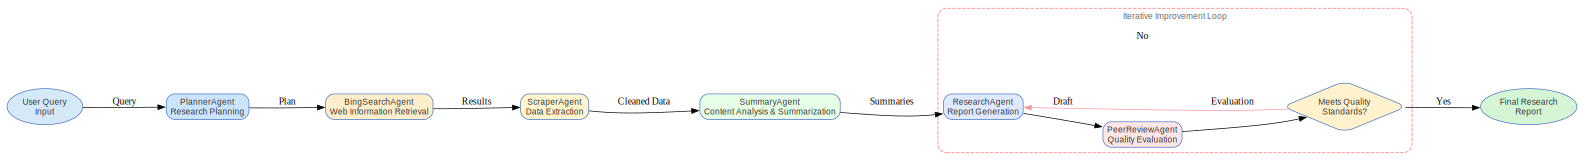

In [9]:
from common.helper import create_research_workflow_diagram_scraper

# This will generate research_workflow_diagram.png and return the Digraph object
workflow_diagram = create_research_workflow_diagram_scraper()
workflow_diagram

Let's start with a sample research query.

In [10]:
# user_query="What big industries will AI have the most affect on?"
user_query="What are the differences between classical machine learning, deep learning and generative AI?"

### Step 1: Research Planning

The PlannerAgent analyzes the research query and creates a structured plan with:

- Research objective - A clear statement of what the research aims to accomplish
- Subtopics - Key areas to explore for comprehensive coverage
- Search queries - Specific queries for each subtopic to gather relevant information
- Success criteria - Metrics to determine research completeness
- Related topics - Additional areas that may provide valuable context

In [11]:
from agents import Runner

plan = await Runner().run(
    starting_agent=planner_agent,
    input=user_query
)

In [12]:
plan.final_output.research_tasks[0].search_queries

['definition of classical machine learning',
 'what is deep learning in AI',
 'generative AI definition and explanation',
 'differences between classical ML, deep learning, and generative AI']

### Step 2: Information Retrieval

The BingSearchAgent executes web searches for each query in our research plan. For each subtopic:

1. Multiple search queries are sent to gather diverse perspectives.
2. The agent returns structured search results with titles, summaries, relevance scores, and URLs.
3. Results are organized by subtopic for further processing.

This step leverages Azure AI Projects with Bing Search integration to identify promising sources.

In [13]:
import os
from tqdm import tqdm
from common.utils_search import extract_agent_response_and_urls

bing_search_agent = project_client.agents.get_agent(agent_id=os.getenv("bingSearchAgentID"))

search_results = []

for subtopic in tqdm(plan.final_output.research_tasks, desc="Subtopics"):
    subtopic_results = {"subtopic": subtopic.subtopic, "queries": []}

    for query in tqdm(subtopic.search_queries, desc=f"Queries ({subtopic.subtopic})", leave=False):
        formatted_query = f"""
        Research the following query: {query}
        This is related to subtopic: {subtopic.subtopic}
        Please provide the information and cite your sources using the available tools.
        """
        try:
            thread = project_client.agents.threads.create()
            message = project_client.agents.messages.create(
                thread_id=thread.id,
                role="user",
                content=formatted_query,
            )

            # Process the run
            run = project_client.agents.runs.create_and_process(
                thread_id=thread.id,
                agent_id=bing_search_agent.id
            )

            agent_response_text, extracted_urls = extract_agent_response_and_urls(project_client, thread.id, query)

            # Add to our results collection
            subtopic_results["queries"].append({
                "query": query,
                "agent_response": agent_response_text,
                "results": extracted_urls
            })

            # Delete the thread after processing
            project_client.agents.threads.delete(thread_id=thread.id)

        except Exception as e:
            print(f"An error occurred processing query '{query}': {e}")
            # Optionally add error information to results
            subtopic_results["queries"].append({
                "query": query,
                "results": [],
                "error": str(e)
            })

    search_results.append(subtopic_results)

Subtopics: 100%|██████████| 4/4 [02:28<00:00, 37.23s/it]


In [14]:
print(f"Planned total search queries: {sum(1 for task in plan.final_output.research_tasks for search_query in task.search_queries)}\n")
print(f"Actually total search queries: {sum(1 for task in search_results for result in task['queries'])}\n")

Planned total search queries: 16

Actually total search queries: 16



### Step 3: Web Content Scraping

The WebScraperAgent processes the URLs and metadata returned by the BingSearchAgent. For each subtopic:

1. Only URLs with a high enough relevance score are selected for scraping.
2. The WebScraperAgent visits each selected URL and extracts the most relevant content, guided by the user query, subtopic, and search result summary.
3. Extracted content is cleaned, deduplicated, and enriched with metadata such as title, source, published date, and extraction method.
4. The resulting structured data is organized by subtopic for downstream analysis and summarization.

This step ensures that only the most promising and contextually relevant web content is collected, providing a high-quality foundation for subsequent summarization and synthesis.

In [15]:
from typing import Set

class ScraperAgentInput(BaseModel):
    url: str
    subtopic: str
    user_query: str
    search_result_title: str
    visited_urls: Set[str] = Field(default_factory=set)
    max_content_length: int = 4000

In [16]:
# TODO: Implement a threshold for relevance score 

# --- Scraping Phase ---
urls_to_process_map = {}

print("Preparing scrape tasks...")
for subtopic_result in search_results:
    subtopic = subtopic_result["subtopic"]
    for query_result in subtopic_result["queries"]:
        query = query_result["query"]
        for result in query_result["results"]:
            if result["url"] not in urls_to_process_map:
            # if result.relevance_score >= MIN_RELEVANCE_SCORE and result.url not in urls_to_process_map:
                urls_to_process_map[result["url"]] = {
                    "subtopic": subtopic,
                    "query": query,
                    "search_result_title": result["title"]
                }

visited_urls_tracker = set(urls_to_process_map.keys())
print(f"Found {len(urls_to_process_map)} unique URLs above threshold to scrape.")

Preparing scrape tasks...
Found 28 unique URLs above threshold to scrape.


In [17]:
from itertools import islice

MAX_SCRAPE_CONTENT_LENGTH = 4000 # Max characters for scrape tool

scrape_tasks = []
num_urls_to_scrape = len(urls_to_process_map)

for url, context in tqdm(islice(urls_to_process_map.items(), num_urls_to_scrape),
                         desc="Preparing scrape tasks",
                         total=num_urls_to_scrape):
    agent_input_model = ScraperAgentInput(
        url=url,
        subtopic=context["subtopic"],
        user_query=context["query"],
        search_result_title=context["search_result_title"],
        visited_urls=visited_urls_tracker,
        max_content_length=MAX_SCRAPE_CONTENT_LENGTH
    )

    scrape_response = await Runner().run(
        starting_agent=web_scraper_agent,
        input=f"Scrape data from the provided URL: {agent_input_model.model_dump_json()}"
    )
    scrape_tasks.append(scrape_response.final_output)

Preparing scrape tasks: 100%|██████████| 28/28 [03:12<00:00,  6.86s/it]


### Step 4: Content Analysis and Summarization

For each scraped result, the SummaryAgent:

1. Extracts key facts, statistics, and insights from the cleaned web content
2. Preserves important technical details, dates, and domain-specific terminology
3. Formats the summary with key insights and detailed paragraph explanations
4. Tracks citations for proper attribution in the final report

This step transforms high-quality scraped data into structured, information-rich summaries that will form the basis of our research report.

In [18]:
from common.utils_summary import collect_contents_and_citations, summarize_content
summarize_per_webpage = False  # True will summarize per web page, False will summarize per subtopic

# Build a lookup for scraped content (using attribute access)
scraped_content_by_url = {
    item.url: item.main_content
    for item in scrape_tasks
    if getattr(item, "main_content", None)
}

mapped_chunks = []

for subtopic_result in tqdm(search_results, desc="Summarizing subtopics"):
    contents, citations = collect_contents_and_citations(subtopic_result, scraped_content_by_url)
    summaries = await summarize_content(contents, summary_agent, Runner, summarize_per_webpage)
    if summarize_per_webpage:
        mapped_chunks.append({
            "subtopic": subtopic_result["subtopic"],
            "summaries": summaries,
            "citations": citations
        })
    else:
        mapped_chunks.append({
            "subtopic": subtopic_result["subtopic"],
            "summaries": summaries,
            "citations": citations
        })

# Filter out empty summaries
mapped_chunks = [c for c in mapped_chunks if c['summaries']]

Summarizing subtopics: 100%|██████████| 4/4 [00:46<00:00, 11.51s/it]


### Step 4: Report Generation and Peer Review

In this final stage:

1. The ResearchAgent synthesizes all summarized content into a comprehensive report
2. The PeerReviewAgent evaluates the report based on completeness, clarity, evidence, and insight
3. If needed, the report is revised based on feedback
4. This cycle continues until quality standards are met

The final report is structured as a cohesive academic-style document with proper citations and a references section.

In [19]:
import json
from common.utils_research import preprocess_research_data

research_input = preprocess_research_data(plan.final_output, mapped_chunks)
research_input_prompt = json.dumps(research_input, indent=2)

final_answer = await Runner().run(
    starting_agent=research_agent,
    input=(
        "Create an exceptionally comprehensive, **paragraph-focused** and detailed research report "
        "using the following content. **Minimize bullet points** and ensure the final text resembles "
        "a cohesive, academic-style paper:\n\n"
        f"{research_input_prompt}\n\n"
        "As a final reminder, don't forget to include the citation list at the end of the report."
    ),
    max_turns=21 # 5 turns are needed for a full collaboration between ResearchAgent and PeerReviewAgent
)

### Extracting the Final Research Report

After the ResearchAgent and PeerReviewAgent complete their collaborative process, we extract the final research report from the agent outputs. The report includes:

1. A clearly defined research objective
2. Multiple sections covering all identified subtopics
3. In-depth analysis with facts, statistics, and insights
4. Proper citations using IEEE format
5. A comprehensive references section

In [20]:
from agents import HandoffCallItem

def extract_research_report(final_answer):
    # If final output is from ResearchAgent, get the report directly
    if hasattr(final_answer.final_output, "research_report"):
        return final_answer.final_output.research_report
    
    # If final output is from PeerReviewAgent, find the latest research report from ResearchAgent
    for item in reversed(final_answer.new_items):  # Start from end to get the latest
        if isinstance(item, HandoffCallItem) and item.agent.name == "ResearchAgent":
            try:
                args = json.loads(item.raw_item.arguments)
                if "research_report" in args:
                    return args["research_report"]
            except (json.JSONDecodeError, AttributeError):
                continue
    
    # If we couldn't find a report
    raise ValueError("No research report found in the conversation history")

research_report = extract_research_report(final_answer)

### Final Report Presentation

The completed research report is displayed below in Markdown format. The report represents a comprehensive analysis of the original query, incorporating insights from multiple web sources and structured in an academic format with proper citations.

In [21]:
from IPython.display import display, Markdown
display(Markdown(research_report))

# Comparative Analysis of Classical Machine Learning, Deep Learning, and Generative AI: Definitions, Methodologies, Applications, and Challenges

## Introduction

The field of artificial intelligence (AI) has undergone dramatic evolution over the past several decades, progressing from rule-based expert systems to sophisticated, data-driven models capable of autonomous learning and content creation. Within this expansive domain, three paradigms stand out for their foundational and transformative roles: classical machine learning (ML), deep learning (DL), and generative AI (GenAI). Each represents a distinct approach to leveraging data and computational power, with unique methodologies, applications, strengths, and limitations. As AI continues to reshape industries and societies, understanding the nuanced distinctions and interconnections among these paradigms is essential for researchers, practitioners, and policymakers alike. This report provides an in-depth, authoritative exploration of classical machine learning, deep learning, and generative AI, synthesizing recent advancements, comparative analyses, and real-world impacts.

## 1. Definitions and Core Concepts

### 1.1 Classical Machine Learning

Classical machine learning, often referred to as traditional or conventional ML, encompasses a set of statistical algorithms designed to identify patterns, relationships, and predictive rules within structured datasets. These algorithms operate within well-defined problem spaces, relying on explicit mathematical models and human-engineered features. The core objective is to enable computers to learn from historical data and make accurate predictions or classifications on new, unseen data. Classic ML algorithms include support vector machines (SVMs), decision trees, logistic regression, k-nearest neighbors (KNN), and ensemble methods such as random forests. These models are prized for their interpretability, computational efficiency, and effectiveness in domains where the data is clean, structured, and the relationships among variables are relatively straightforward [1].

### 1.2 Deep Learning

Deep learning represents a significant advancement within the broader ML paradigm, characterized by the use of artificial neural networks with multiple hidden layers. Inspired by the structure and function of the human brain, deep learning models are capable of automatic feature extraction from raw, high-dimensional, and often unstructured data such as images, audio, and natural language text. The hierarchical architecture of deep neural networks enables them to learn complex, non-linear representations and capture intricate patterns that are often inaccessible to classical ML algorithms. Notable deep learning architectures include convolutional neural networks (CNNs) for image processing, recurrent neural networks (RNNs) and long short-term memory networks (LSTMs) for sequential data, and transformer models for language understanding. Deep learning has become the backbone of many state-of-the-art AI systems, powering breakthroughs in computer vision, speech recognition, and natural language processing [2][3].

### 1.3 Generative AI

Generative AI marks a paradigm shift within deep learning, focusing on the autonomous creation of new, original data that closely resembles or extends beyond the patterns found in training datasets. Unlike traditional ML and DL models, which are primarily designed for prediction or classification, generative AI models are engineered to synthesize novel content—text, images, audio, video, and code—by learning the underlying statistical distributions of their input data. The most prominent generative architectures include generative adversarial networks (GANs), variational autoencoders (VAEs), and large language models (LLMs) such as GPT (Generative Pre-trained Transformer) and BERT (Bidirectional Encoder Representations from Transformers). Generative AI has demonstrated the ability to produce outputs that are often indistinguishable from human-created content, passing benchmarks like the Turing test and enabling new forms of creative and adaptive machine intelligence [4][5].

### 1.4 Hierarchical Relationship

The relationship among these paradigms can be visualized as a nested hierarchy: artificial intelligence encompasses machine learning, which in turn includes deep learning, with generative AI representing a specialized subset of deep learning. This hierarchy reflects increasing levels of complexity, data requirements, and computational demands, as well as expanding capabilities from rule-based reasoning to autonomous content generation.

## 2. Key Methodologies and Algorithms

### 2.1 Classical Machine Learning Algorithms

Classical ML algorithms are grounded in statistical theory and rely heavily on human expertise for feature selection and engineering. The most widely used classical algorithms include:

- **Support Vector Machines (SVMs):** SVMs seek to find the optimal hyperplane that separates data points of different classes with the maximum margin. They are effective for both linear and non-linear classification tasks, especially in high-dimensional spaces.
- **Decision Trees:** These models recursively partition the data based on feature thresholds, creating a tree-like structure where each node represents a decision rule. Decision trees are intuitive, interpretable, and can handle both classification and regression tasks.
- **Logistic Regression:** A statistical model used for binary classification, logistic regression estimates the probability of a categorical outcome based on input features. It is valued for its simplicity and interpretability.
- **K-Nearest Neighbors (KNN):** This non-parametric algorithm classifies new data points based on the majority class among their k closest neighbors in the feature space.
- **Ensemble Methods:** Techniques such as random forests and gradient boosting combine multiple base models to improve predictive performance and reduce overfitting.

These algorithms are typically applied to structured data, where the relationships among variables are well understood and the feature space is manageable. The reliance on manual feature engineering, while labor-intensive, allows for greater transparency and explainability in model decisions [1].

### 2.2 Deep Learning Architectures

Deep learning models are distinguished by their ability to automatically learn hierarchical feature representations from raw data. Key architectures include:

- **Convolutional Neural Networks (CNNs):** Designed for spatial data such as images, CNNs use convolutional layers to detect local patterns and hierarchical structures. They have achieved remarkable success in image classification, object detection, and medical imaging.
- **Recurrent Neural Networks (RNNs):** RNNs are tailored for sequential data, such as time series and natural language, by incorporating feedback loops that allow information to persist across time steps. Variants like LSTMs and GRUs address the vanishing gradient problem and enable the modeling of long-term dependencies.
- **Transformer Models:** Introduced in 2017, transformers use self-attention mechanisms to capture global dependencies in sequential data, revolutionizing natural language processing and enabling the development of large language models.

Deep learning models require large volumes of labeled data and significant computational resources for training. Their automatic feature extraction capabilities reduce the need for manual intervention but often result in "black box" models with limited interpretability [2][3].

### 2.3 Generative AI Methodologies

Generative AI leverages advanced deep learning architectures to synthesize new data. The principal methodologies include:

- **Generative Adversarial Networks (GANs):** GANs consist of a generator network that creates synthetic data and a discriminator network that evaluates its authenticity. Through adversarial training, the generator learns to produce increasingly realistic outputs, while the discriminator becomes adept at distinguishing real from fake data. GANs have been instrumental in image synthesis, style transfer, and data augmentation.
- **Variational Autoencoders (VAEs):** VAEs encode input data into a latent space and then decode it to reconstruct the original data, enabling the generation of new samples by sampling from the latent space. VAEs are used for image generation, anomaly detection, and representation learning.
- **Large Language Models (LLMs):** Models like GPT-4 and BERT are trained on massive corpora of text, learning to predict the next word or token in a sequence. These models can generate coherent, contextually relevant text, answer questions, summarize documents, and even write code.
- **Multimodal Models:** Recent advancements have led to models capable of processing and generating content across multiple modalities, such as text, images, audio, and video. These models underpin applications like DALL-E (text-to-image generation) and CLIP (image-text alignment).

Generative AI models are typically trained on vast, often unlabeled datasets, leveraging self-supervised or unsupervised learning techniques. The operational workflow often involves a user prompt, which is processed by the model to generate new content that is statistically probable given the training data [4][5].

### 2.4 Agentic Retrieval and Retrieval-Augmented Generation (RAG)

A notable methodological advancement in generative AI is the integration of agentic retrieval and retrieval-augmented generation (RAG). Agentic retrieval, as implemented in platforms like Azure AI Search, introduces a parallel, LLM-driven query processing architecture that leverages user conversation history and advanced query planning. This approach combines keyword and semantic search, parallel subquery execution, and LLM-based reasoning to deliver high-quality, contextually grounded results. RAG pipelines enhance generative models by grounding their outputs in authoritative data sources, improving accuracy, explainability, and user trust [6].

## 3. Applications and Use Cases

### 3.1 Classical Machine Learning Applications

Classical ML remains indispensable in domains where data is structured, relationships are well understood, and interpretability is paramount. Common applications include:

- **Fraud Detection:** Logistic regression and decision trees are widely used to identify anomalous transactions in banking and finance.
- **Customer Segmentation:** Clustering algorithms and SVMs help businesses segment customers based on purchasing behavior, enabling targeted marketing.
- **Predictive Maintenance:** Regression models predict equipment failures based on sensor data, reducing downtime and maintenance costs.
- **Credit Scoring:** Decision trees and ensemble methods assess creditworthiness by analyzing historical loan data.

These applications benefit from the transparency and efficiency of classical ML models, which can be deployed with relatively modest computational resources [1].

### 3.2 Deep Learning Use Cases

Deep learning has unlocked new possibilities in processing unstructured data and solving complex tasks. Notable use cases include:

- **Image Recognition:** CNNs power facial recognition, medical imaging diagnostics, and autonomous vehicle perception systems.
- **Speech Recognition:** RNNs and LSTMs enable voice assistants, transcription services, and real-time translation.
- **Natural Language Processing:** Transformer models underpin chatbots, sentiment analysis, document summarization, and machine translation.
- **Autonomous Systems:** Deep reinforcement learning drives advancements in robotics, gaming, and self-driving cars.

The ability of deep learning models to learn directly from raw data has led to significant improvements in accuracy and performance across these domains, albeit at the cost of increased computational demands and reduced interpretability [2][3][7].

### 3.3 Generative AI Applications Across Industries

Generative AI is revolutionizing content creation and automation across a wide array of industries. Its applications include:

- **Text Generation:** LLMs like ChatGPT and Google Bard generate fluent, contextually appropriate text for report writing, proposal drafting, meeting summarization, and customer service interactions.
- **Image Synthesis:** GANs and diffusion models create realistic images for advertising, product design, and entertainment. Tools like Midjourney and DALL-E enable rapid prototyping and creative exploration.
- **Audio and Music Generation:** Systems such as ElevenLabs and Descript’s Overdub produce lifelike voiceovers, custom music compositions, and audio editing for media production.
- **Video Generation and Editing:** Generative models automate tasks like scene generation, motion interpolation, and video upscaling, streamlining content creation in marketing and entertainment.
- **Code Generation:** Tools like GitHub Copilot assist developers by drafting code, automating quality assurance, and generating documentation, accelerating software development cycles.
- **Healthcare:** Generative AI automates clinical documentation, enhances medical imaging, and accelerates drug discovery by generating molecular structures and predictive models.
- **Marketing and Advertising:** AI-generated copy, visuals, and campaign concepts enable personalized messaging and rapid A/B testing.
- **Manufacturing:** Generative design optimizes product development, while synthetic data generation supports predictive maintenance and quality control.
- **Financial Services:** Automated report generation, compliance documentation, and synthetic data for risk modeling are transforming operations.
- **Media and Entertainment:** Scriptwriting, storyboarding, visual effects, and music composition are being enhanced or automated, enabling new forms of creative expression.

The economic impact of generative AI is substantial. Gartner predicts over 100 million users by 2026, while McKinsey estimates a potential global economic impact of $2.6–$4.4 trillion annually. These gains are driven by productivity improvements, automation of repetitive tasks, and the creation of new products and services [8][9][10][11].

### 3.4 Comparative Table of Applications

| Paradigm                | Typical Data Type   | Key Applications                                            | Example Algorithms/Models         |
|-------------------------|--------------------|-------------------------------------------------------------|-----------------------------------|
| Classical ML            | Structured         | Fraud detection, credit scoring, predictive maintenance      | SVM, Decision Trees, Logistic Reg.|
| Deep Learning           | Unstructured       | Image/speech recognition, NLP, autonomous driving           | CNN, RNN, Transformer             |
| Generative AI           | Unstructured/Multi | Text/image/audio/video/code generation, synthetic data       | GAN, VAE, LLM (GPT, BERT)         |

## 4. Strengths, Limitations, and Challenges

### 4.1 Strengths

#### Classical Machine Learning

The primary strengths of classical ML lie in its interpretability, efficiency, and suitability for structured data. Models such as decision trees and logistic regression provide clear, understandable decision rules, facilitating transparency and regulatory compliance. Training times are generally short, and the computational requirements are modest, making classical ML accessible for organizations with limited resources. These models excel in applications where the relationships among variables are well understood and the feature space is manageable. The reliance on manual feature engineering, while labor-intensive, allows domain experts to incorporate valuable insights and ensure model relevance [1].

#### Deep Learning

Deep learning’s most significant advantage is its capacity for automatic feature extraction and hierarchical representation learning. This enables the processing of raw, high-dimensional, and unstructured data, unlocking new possibilities in computer vision, speech recognition, and natural language processing. Deep learning models consistently outperform classical ML in tasks involving complex, non-linear relationships and large datasets. The scalability of deep neural networks allows them to adapt to diverse applications, from image classification to autonomous systems. Recent advancements in hardware (e.g., GPUs, TPUs) and distributed computing have further accelerated deep learning research and deployment [2][3][7].

#### Generative AI

Generative AI’s transformative strength lies in its ability to autonomously create new, original content that is contextually relevant and often indistinguishable from human-generated data. This capability is revolutionizing content creation, automation, and personalization across industries. Generative AI models can leverage both labeled and unlabeled data, increasing their flexibility and applicability. The integration of multimodal capabilities enables the synthesis of text, images, audio, and video, supporting innovative applications in healthcare, marketing, entertainment, and beyond. Generative AI is also driving the development of foundation models—large, pre-trained models that can be fine-tuned for a wide range of downstream tasks, accelerating AI adoption and reducing time to value [4][5][8][9].

### 4.2 Limitations and Challenges

#### Classical Machine Learning

Despite its strengths, classical ML is limited by its reliance on manual feature engineering and its inability to process unstructured data effectively. The performance of classical models often plateaus as the complexity and dimensionality of the data increase. These models may struggle with large-scale datasets and are less adaptable to evolving data distributions. The need for domain expertise in feature selection can also introduce biases and limit generalizability [1].

#### Deep Learning

Deep learning models, while powerful, are computationally intensive and require vast amounts of labeled data for optimal performance. The training process can be time-consuming and resource-intensive, necessitating specialized hardware and infrastructure. Deep neural networks often function as "black boxes," making it difficult to interpret their decision processes and diagnose errors. This lack of transparency poses challenges for regulatory compliance and user trust, particularly in high-stakes applications such as healthcare and finance. Deep learning models are also susceptible to adversarial attacks and may exhibit unexpected behaviors when exposed to out-of-distribution data [2][3][7].

#### Generative AI

Generative AI introduces a new set of challenges, including ethical concerns, potential misuse, and the risk of generating biased or misleading content. The reliance on large, diverse datasets can propagate existing biases and amplify societal inequalities. Intellectual property issues arise when generative models are trained on copyrighted material, raising questions about ownership, attribution, and compensation. The authenticity of generated content is difficult to verify, increasing the risk of misinformation and manipulation. Generative AI models are also prone to "hallucinations," where outputs are plausible but factually incorrect. Robust governance frameworks, transparency in model development, and ongoing stakeholder dialogue are essential to address these risks [4][5][8][9].

### 4.3 Comparative Analysis

The choice among classical ML, deep learning, and generative AI depends on several factors:

- **Data Volume and Type:** Classical ML is optimal for small, structured datasets; deep learning and generative AI require large, often unstructured datasets.
- **Interpretability:** Classical ML offers transparency; deep learning and generative AI are less interpretable.
- **Output Needs:** Prediction and classification tasks favor classical ML or deep learning; content generation tasks require generative AI.
- **Computational Resources:** Deep learning and generative AI demand significant computational power and infrastructure.
- **Ethical and Governance Considerations:** Generative AI necessitates robust oversight to mitigate risks of bias, hallucination, and misuse.

The development of foundation models and retrieval-augmented generation pipelines is accelerating AI adoption, with evidence suggesting up to 70% faster time to value compared to traditional approaches. However, successful implementation across all AI paradigms requires careful data selection, quality assurance, governance, and model selection tailored to the specific use case [6][8][9].

## 5. Recent Advancements and Trends (2023–2025)

### 5.1 Surge in Generative AI Adoption

The release of advanced generative models such as OpenAI’s ChatGPT, Google Bard, and multimodal systems like DALL-E and Midjourney has catalyzed a surge in generative AI adoption across industries. These models have demonstrated the ability to pass the Turing test, generate content indistinguishable from human work, and automate complex creative tasks. The rapid proliferation of generative AI is evidenced by exponential growth in user adoption, with Gartner projecting over 100 million users by 2026 and McKinsey estimating a potential global economic impact of up to $4.4 trillion annually [8][9][10][11].

### 5.2 Advances in Neural Network Architectures

Recent years have witnessed significant advancements in neural network architectures, particularly the development of transformer models and large language models (LLMs). Transformers have revolutionized natural language processing by enabling models to capture long-range dependencies and process sequences in parallel. The scaling of LLMs, with billions of parameters and training on massive corpora, has unlocked new capabilities in language understanding, generation, and multimodal processing [4][5].

### 5.3 Emergence of Multimodal and Foundation Models

The integration of multimodal capabilities—processing and generating text, images, audio, and video—has expanded the scope of generative AI applications. Foundation models, which are large, pre-trained models adaptable to a wide range of tasks, are accelerating AI deployment and reducing the need for task-specific training. These models are enabling new forms of human-computer interaction, personalized content creation, and adaptive learning experiences [4][5][8][9].

### 5.4 Retrieval-Augmented Generation and Agentic Retrieval

The development of retrieval-augmented generation (RAG) pipelines and agentic retrieval architectures is enhancing the accuracy, explainability, and contextual grounding of generative AI systems. By integrating LLM-driven reasoning, parallel subquery execution, and grounding outputs in authoritative data sources, these approaches are addressing the limitations of traditional and even modern search systems. Agentic retrieval is particularly well-suited for conversational AI and knowledge agent scenarios, where understanding user intent and providing explainable, high-quality results are paramount [6].

### 5.5 Ethical, Legal, and Societal Implications

The rapid advancement and deployment of generative AI have intensified discussions around ethics, intellectual property, data privacy, and societal impact. Concerns about data bias, misinformation, deepfakes, and the potential for misuse are prompting calls for robust governance frameworks, transparency in model development, and ongoing stakeholder engagement. Legal questions regarding the use of copyrighted material in training data and the attribution of generated content remain unresolved, necessitating new regulatory approaches and industry standards [4][5][8][9].

## 6. Data Visualizations and Comparative Analyses

### 6.1 Timeline of Major Developments

| Year | Milestone                                      |
|------|------------------------------------------------|
| 1950 | Alan Turing proposes the Turing test           |
| 1957 | Perceptron (early neural network) introduced   |
| 1967 | Nearest Neighbor algorithm published           |
| 1986 | Backpropagation popularized for neural nets    |
| 1995 | Support Vector Machines (SVMs) introduced      |
| 2006 | Deep Belief Networks spark deep learning boom  |
| 2012 | AlexNet wins ImageNet, revolutionizing DL      |
| 2017 | Transformer architecture introduced            |
| 2018 | BERT (Bidirectional Encoder Representations)   |
| 2020 | GPT-3 released (175B parameters)               |
| 2022 | DALL-E 2, Midjourney, Stable Diffusion         |
| 2023 | ChatGPT, GPT-4, Gemini, multimodal LLMs        |

### 6.2 Hierarchical Breakdown of AI Paradigms

```
Artificial Intelligence
├── Machine Learning
│   ├── Classical ML
│   └── Deep Learning
│       └── Generative AI
```

### 6.3 Impact Assessment Matrix Across Industries

| Industry         | Classical ML | Deep Learning | Generative AI |
|------------------|-------------|---------------|---------------|
| Healthcare       | High        | High          | Growing       |
| Marketing        | Moderate    | High          | High          |
| Manufacturing    | High        | Moderate      | Growing       |
| Financial Svcs   | High        | Moderate      | Moderate      |
| Media/Entmt      | Moderate    | High          | High          |
| Software Dev     | Moderate    | High          | High          |

### 6.4 Adoption and Performance Metrics

Recent surveys and market analyses indicate that organizations adopting generative AI report up to 70% faster time to value compared to traditional AI approaches, with productivity gains and automation driving substantial economic impact. Adoption rates are highest in sectors with large volumes of unstructured data and high demand for content creation, such as media, marketing, and healthcare [8][9][10][11].

## Conclusion

The evolution from classical machine learning to deep learning and generative AI represents a continuum of increasing complexity, capability, and impact within the field of artificial intelligence. Classical ML provides a foundation of interpretable, efficient models for structured data and well-defined tasks. Deep learning extends these capabilities to unstructured data and complex pattern recognition, powering breakthroughs in vision, speech, and language. Generative AI, as the latest frontier, enables machines to create, innovate, and adapt, transforming industries and raising profound ethical, legal, and societal questions. The choice among these paradigms depends on data characteristics, interpretability requirements, computational resources, and desired outcomes. As AI continues to advance, a nuanced understanding of these distinctions is essential for harnessing its potential while navigating its challenges. Ongoing research, responsible governance, and interdisciplinary collaboration will be critical to ensuring that AI serves as a force for innovation, equity, and societal benefit.

## References

[1] Classic and Adaptive machines - GeeksforGeeks, https://www.geeksforgeeks.org/classic-and-adaptive-machines/

[2] Deep Learning vs. Traditional Machine Learning: What's the Difference ..., https://makez.ai/deep-learning-vs-traditional-machine-learning-whats-the-difference/

[3] AI vs. Machine Learning vs. Deep Learning vs. Neural Networks - IBM, https://www.ibm.com/think/topics/ai-vs-machine-learning-vs-deep-learning-vs-neural-networks

[4] What is Generative AI? | Definition, Examples, & Analysis - Perlego, https://www.perlego.com/knowledge/study-guides/what-is-generative-ai/

[5] What is generative AI? - IBM Research, https://research.ibm.com/blog/what-is-generative-AI

[6] Agentic Retrieval - Azure AI Search | Microsoft Learn, https://learn.microsoft.com/en-us/azure/search/search-agentic-retrieval-concept

[7] Deep Learning Examples: Practical Applications in Real Life, https://www.geeksforgeeks.org/deep-learning-examples/

[8] Generative AI Applications: 16 Real-World Examples | RTB House, https://www.rtbhouse.com/blog/16-examples-of-generative-ai-applications

[9] 28 Generative AI Examples (2025): Use Cases Across Industries, https://www.lindy.ai/blog/generative-ai-examples

[10] 20 Examples of Generative AI Applications Across Industries, https://www.coursera.org/articles/generative-ai-applications

[11] Top 50 Deep Learning Use Case & Case Studies in 2025 - AIMultiple, https://research.aimultiple.com/deep-learning-applications/

### Research Workflow Visualization

Below we can see the detailed steps in the research and review process, showing how the ResearchAgent and PeerReviewAgent collaborated to produce the final report. This visualization helps us understand how many iterations were required to meet quality standards.

In [22]:
from common.helper import pretty_print_agent_workflow
pretty_print_agent_workflow(final_answer)

🔍 AGENT WORKFLOW: 'Create an exceptionally comprehensive, **paragraph-focused** and detailed research report using the following content. **Minimize bullet points** and ensure the final text resembles a cohesive, academic-style paper:

{
  "objective": "To comprehensively analyze and articulate the key differences between classical machine learning, deep learning, and generative AI, including their definitions, methodologies, applications, strengths, and limitations.",
  "aggregated_summaries": [
    {
      "subtopic": "Definitions and Core Concepts",
      "summaries": "Acknowledge: The following synthesis integrates information from multiple search results on the subtopic of classic machine learning algorithms (\"classic machines\") and generative AI, including their definitions, methodologies, applications, and recent developments.\n\n## Key Insights\n- **Classic machine learning algorithms (\"classic machines\") use statistical techniques to find patterns and make predictions with